<u>**Scratch Work for the Final Project**<u>

In [1]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import streamlit as st
from tabulate import tabulate
import plotly.express as px

In [2]:
### Load Data
file_path = "data/netflix_titles.csv"      # Make sure the file is in your active directory
df = pd.read_csv(file_path)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
def load_data(file_path = "data/netflix_titles.csv"):
    df = pd.read_csv(file_path)
    return df

In [4]:
### Functions to clean the data:
def cleanNetflixData(df,
                     estimateSeasonMinutes=False,
                     episodesPerSeason=10,
                     minutesPerEpisode=45,
                     explodeGenres=False,
                     standardizeGenres=True): # Added option to standardize genres

    df = df.copy()

    # --- 0) Trim whitespace in all object columns & normalize empties ---
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].replace({"": np.nan, "nan": np.nan, "None": np.nan})

    # --- 1) Dates: parse and derive parts ---
    if "date_added" in df.columns:
        df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
        df["year_added"]  = df["date_added"].dt.year.astype("Int64")
        df["month_added"] = df["date_added"].dt.month.astype("Int64")

    # --- 2) Type normalization ---
    if "type" in df.columns:
        df["type"] = df["type"].str.title()  # 'Movie' / 'Tv Show' -> 'Movie' / 'Tv Show'
        df["type"] = df["type"].replace({"Tv Show": "TV Show"})

    # --- 3) Rating normalization (unify common TV-* variants) ---
    if "rating" in df.columns:
        r = df["rating"].str.upper().str.replace(" ", "-", regex=False)
        tv_fixes = {
            "TV-MA": "TV-MA", "TV-14": "TV-14", "TV-PG": "TV-PG", "TV-G": "TV-G",
            "TV-Y7": "TV-Y7", "TV-Y": "TV-Y"
        }
        # normalize common spaced forms like "TV MA", "TV 14", etc.
        r = r.replace({
            "TVMA": "TV-MA", "TV14": "TV-14", "TVPG": "TV-PG", "TVG": "TV-G",
            "TVY7": "TV-Y7", "TVY": "TV-Y"
        })
        df["rating"] = r.replace(tv_fixes)

    # --- 4) Duration: extract minutes and seasons ---
    df["duration_minutes"] = pd.to_numeric(
        df.get("duration", pd.Series(index=df.index, dtype="object"))
          .str.extract(r"(\d+)\s*min", expand=False), errors="coerce"
    ).astype("Int64")

    df["seasons"] = pd.to_numeric(
        df.get("duration", pd.Series(index=df.index, dtype="object"))
          .str.extract(r"(\d+)\s*Season", flags=re.IGNORECASE, expand=False),
        errors="coerce"
    ).astype("Int64")

    # Optionally estimate TV show minutes
    if estimateSeasonMinutes:
        est = df["seasons"].astype("Float64") * episodesPerSeason * minutesPerEpisode
        df["duration_minutes"] = df["duration_minutes"].astype("Float64")
        df["duration_minutes"] = df["duration_minutes"].fillna(est).round().astype("Int64")

    # --- 5) Countries: split & primary country ---
    if "country" in df.columns:
        df["country"] = df["country"].fillna("Unknown")
        df["countries"] = df["country"].str.split(r"\s*,\s*")
        df["primary_country"] = df["countries"].apply(lambda xs: xs[0] if isinstance(xs, list) and len(xs) else "Unknown")

    # --- 6) Director / Cast: fill NaN with 'Unknown' for easier grouping & add flags ---
    for c in ["director", "cast"]:
        if c in df.columns:
            df[f"has_{c}"] = df[c].notna() # Add flag for missing director/cast
            df[c] = df[c].fillna("Unknown")


    # --- 7) Genres: split; optionally explode & standardize ---
    if "listed_in" in df.columns:
        df["genres"] = df["listed_in"].fillna("Unknown").str.split(r"\s*,\s*")
        if standardizeGenres:
             # Simple standardization: remove " TV Shows", " Movies", " Series" etc.
            df["genres"] = df["genres"].apply(lambda genre_list: [
                re.sub(r'\s*(TV Shows?|Movies?|Series?|Dramas?)$', '', genre, flags=re.IGNORECASE).strip()
                for genre in genre_list
            ])
    else:
        df["genres"] = [[] for _ in range(len(df))]


    genres_exploded = None
    if explodeGenres:
        genres_exploded = (
            df[["show_id", "title", "genres"]]
            .explode("genres", ignore_index=False)
            .rename(columns={"genres": "genre"})
            .reset_index(drop=False)
            .rename(columns={"index": "row_idx"})
        )

    # --- 8) Dtypes & duplicates ---
    if "release_year" in df.columns:
        df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").astype("Int64")
        # Basic validation for release year (e.g., not in the future, not extremely old)
        current_year = pd.Timestamp('now').year
        df.loc[df['release_year'] > current_year + 1, 'release_year'] = pd.NA # Assuming release year shouldn't be more than 1 year in the future
        df.loc[df['release_year'] < 1900, 'release_year'] = pd.NA # Assuming release year shouldn't be before 1900 (adjust as needed)


    df = df.drop_duplicates(subset=["show_id"]).reset_index(drop=True)

    # --- 9) Helpful flags ---
    df["is_movie"] = (df.get("type", "") == "Movie")
    df["is_tv"]    = (df.get("type", "") == "TV Show")


    # --- 10) Extract release month and day (if release_year is valid) ---
    if "release_year" in df.columns:
        # Create a temporary date column to extract month and day, handling NaT
        temp_date = pd.to_datetime(df['release_year'], format='%Y', errors='coerce')
        df['release_month'] = temp_date.dt.month.astype('Int64')
        df['release_day'] = temp_date.dt.day.astype('Int64')


    return (df, genres_exploded) if explodeGenres else (df, None)


In [5]:
# Need the _ since the data cleaning function returns 2 objects (including the None)
df_clean, _ = cleanNetflixData(df)

df_clean.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,seasons,countries,primary_country,has_director,has_cast,genres,is_movie,is_tv,release_month,release_day
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,...,<NA>,[United States],United States,True,False,[Documentaries],True,False,1,1
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,...,2,[South Africa],South Africa,False,True,"[International, TV, TV Mysteries]",False,True,1,1
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,...,1,[Unknown],Unknown,True,True,"[Crime, International, TV Action & Adventure]",False,True,1,1
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,1 Season,...,1,[Unknown],Unknown,False,False,"[Docu, Reality TV]",False,True,1,1
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,...,2,[India],India,False,True,"[International, Romantic, TV Comedies]",False,True,1,1


In [7]:
df_clean.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'year_added', 'month_added', 'duration_minutes', 'seasons', 'countries',
       'primary_country', 'has_director', 'has_cast', 'genres', 'is_movie',
       'is_tv', 'release_month', 'release_day'],
      dtype='object')

In [ ]:
def plot_rating_counts_by_year(df, year=2016, label="Movies and TV Shows"):
    df_ratings = df.dropna(subset=['release_year', 'rating'])
    df_ratings = df_ratings[df_ratings['release_year'] >= year]

    rating_counts = df_ratings.groupby(['release_year', 'rating']).size().unstack(fill_value=0)
    rating_order = rating_counts.sum().sort_values(ascending=False).index
    rating_counts = rating_counts[rating_order]

    fig, ax = plt.subplots(figsize=(10, 8))
    bottom = pd.Series([0]*rating_counts.shape[0], index=rating_counts.index)
    colors = plt.cm.tab20.colors

    for i, rating in enumerate(rating_counts.columns):
        ax.barh(
            rating_counts.index,
            rating_counts[rating],
            left=bottom,
            label=rating,
            color=colors[i % len(colors)]
        )
        for y, x in enumerate(bottom + rating_counts[rating]/2):
            count = rating_counts[rating].iloc[y]
            if count > 20:
                ax.text(x, rating_counts.index[y], str(count),
                        ha='center', va='center', fontsize=9, color='white')
        bottom += rating_counts[rating]

    ax.set_xlabel(f'Number of {label}')
    ax.set_ylabel('Release Year')
    ax.set_title(f'Stacked Count of {label} Ratings from {year} onwards (Counts > 20)')
    ax.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    st.pyplot(fig)

In [10]:
# Movies only
df_movies = df_clean[df_clean['type'] == 'Movie'].copy()

# TV Shows only
df_tv = df_clean[df_clean['type'] == 'TV Show'].copy()

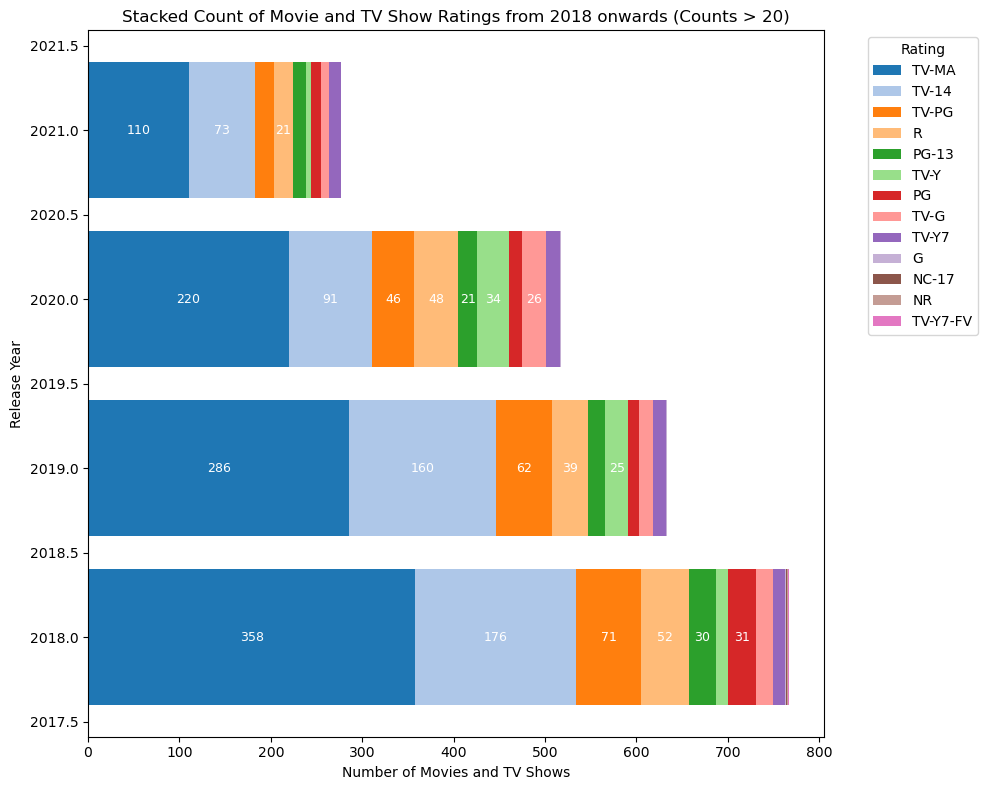

In [11]:
plot_rating_counts_by_year(df_movies, 2018)

In [ ]:
### Same but as styled table
def show_rating_table(df, year = 2016, label = "Movies and TV Shows"):
    df_ratings = df.dropna(subset=['release_year', 'rating'])
    df_ratings = df_ratings[df_ratings['release_year'] >= year]

    rating_counts = df_ratings.groupby(['release_year', 'rating']).size().unstack(fill_value=0)
    styled_table = rating_counts.style.background_gradient(cmap='YlGnBu', axis=None)\
                                       .set_caption(f"{label} Ratings Count per Year")                         
    st.dataframe(styled_table)

In [23]:
show_rating_table(df_movies, label = "Movies")

rating,74-MIN,G,NC-17,NR,PG,PG-13,R,TV-14,TV-G,TV-MA,TV-PG,TV-Y,TV-Y7,TV-Y7-FV,UR
release_year,,,,,,,,,,,,,,,
2016,0,3,0,20,14,34,85,140,13,273,52,8,13,2,1
2017,1,1,0,2,15,32,73,182,20,337,80,13,10,0,0
2018,0,2,1,1,31,30,52,176,18,358,71,13,13,1,0
2019,0,1,0,0,12,19,39,160,15,286,62,25,14,0,0
2020,0,1,0,0,15,21,48,91,26,220,46,34,15,0,0
2021,0,0,0,0,11,14,21,73,9,110,20,6,13,0,0


In [41]:
def plot_top_genres_by_country(df, country='United States', top_n=5):
    df_country = df[df['country'] == country].dropna(subset=['listed_in', 'release_year'])
    df_genres = df_country.assign(genre=df_country['listed_in'].str.split(', ')).explode('genre')

    genre_counts = df_genres.groupby(['release_year', 'genre']).size().reset_index(name='count')
    top_genres = genre_counts.groupby('genre')['count'].sum().sort_values(ascending=False).head(top_n).index
    genre_counts_top = genre_counts[genre_counts['genre'].isin(top_genres)]

    fig, ax = plt.subplots(figsize=(14, 6))
    sns.lineplot(data=genre_counts_top, x='release_year', y='count', hue='genre', marker='o', ax=ax)
    ax.set_title(f'Top {top_n} Genres in {country} Over Time')
    ax.set_xlabel('Release Year')
    ax.set_ylabel('Number of Projects')
    ax.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    #st.pyplot(fig)

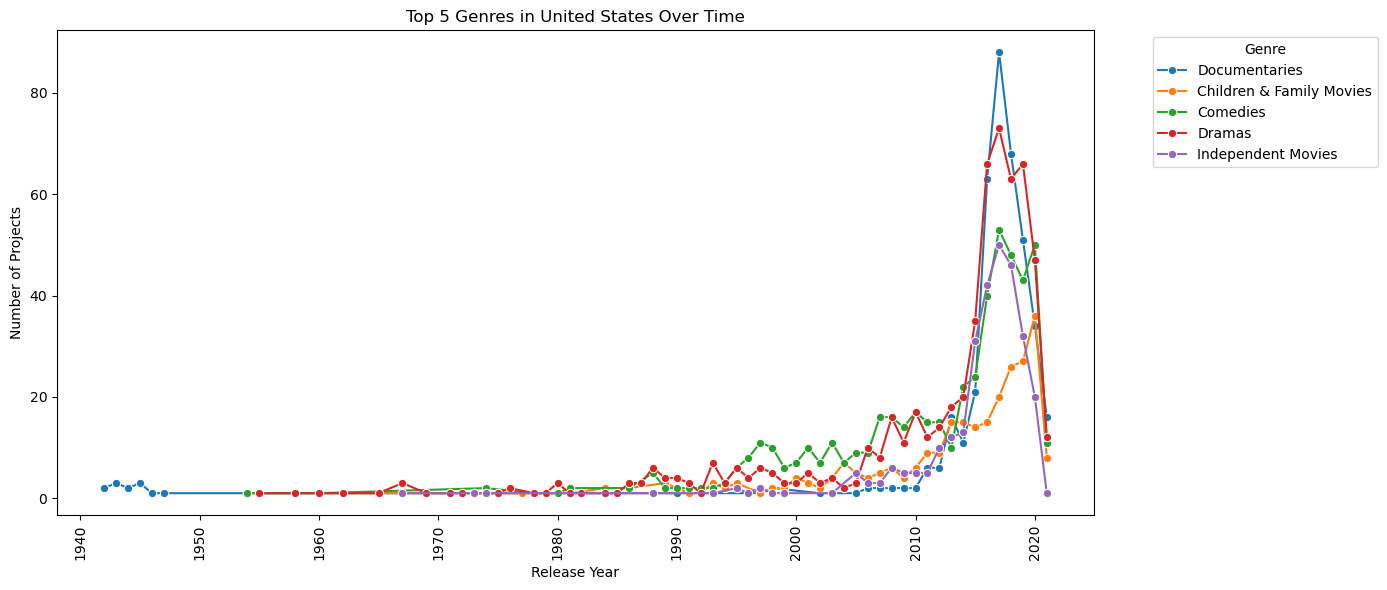

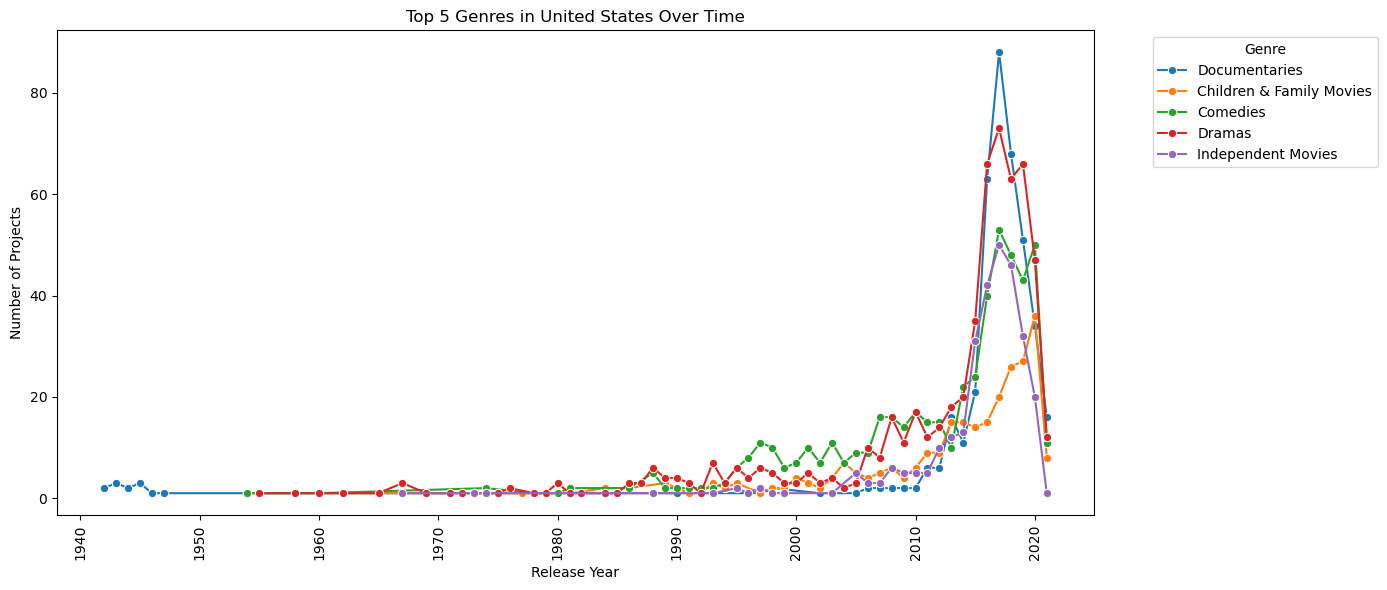

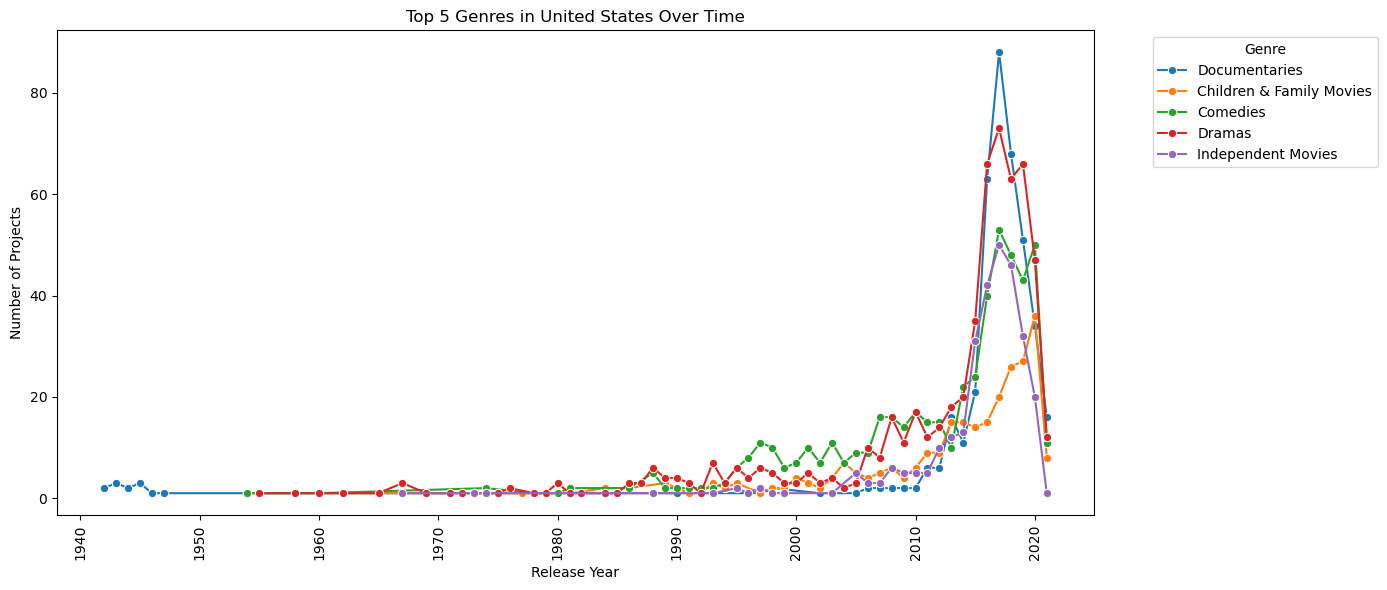

In [42]:
plot_top_genres_by_country(df_clean)

In [36]:
df_clean.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'year_added', 'month_added', 'duration_minutes', 'seasons', 'countries',
       'primary_country', 'has_director', 'has_cast', 'genres', 'is_movie',
       'is_tv', 'release_month', 'release_day'],
      dtype='object')

In [8]:
# Movies only
df_movies = df_clean[df_clean['type'] == 'Movie'].copy()

# TV Shows only
df_tv = df_clean[df_clean['type'] == 'TV Show'].copy()

df_movies.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,seasons,countries,primary_country,has_director,has_cast,genres,is_movie,is_tv,release_month,release_day
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,...,<NA>,[United States],United States,True,False,[Documentaries],True,False,1,1
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",Unknown,2021-09-24,2021,PG,91 min,...,<NA>,[Unknown],Unknown,True,True,[Children & Family],True,False,1,1
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",2021-09-24,1993,TV-MA,125 min,...,<NA>,"[United States, Ghana, Burkina Faso, United Ki...",United States,True,True,"[, Independent, International]",True,False,1,1
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021-09-24,2021,PG-13,104 min,...,<NA>,[United States],United States,True,True,"[Comedies, ]",True,False,1,1
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic",2021-09-23,2021,TV-MA,127 min,...,<NA>,"[Germany, Czech Republic]",Germany,True,True,"[, International]",True,False,1,1


In [9]:
### -------- Step 1: Load IMDB Datasets -------- ###

# Load titles
basics = pd.read_csv(
    "data/title.basics.tsv",
    sep="\t",
    na_values="\\N",
    usecols=["tconst", "primaryTitle", "originalTitle", "startYear", "titleType"]
)
# Load ratings
ratings = pd.read_csv(
    "data/title.ratings.tsv",
    sep="\t",
    na_values="\\N"
)


### -------- Step 2: Merge Datasets -------- ###

imdb = basics.merge(ratings, on="tconst", how="inner")


### -------- Step 3: Filter to Movies Only -------- ###

imdb_movies = imdb[imdb['titleType'] == "movie"].copy()


### -------- Step 4: Merge with Netflix Movies -------- ###

# Uses clean movies data using Aidan's cleaning function, filter so type is movie
movie_ratings_data = df_movies.merge(
    imdb_movies,
    how = "inner",
    left_on="title",
    right_on = "primaryTitle"
)

### -------- Step 5: Drop Duplicaet Movies -------- ###

# Sort the dataframe so that for each title, the row with the highest numVotes comes first
movie_ratings_data_sorted = movie_ratings_data.sort_values(by='numVotes', ascending=False)

# Drop duplicates based on 'title', keeping the first (which has the highest numVotes)
movie_ratings_data_deduped = movie_ratings_data_sorted.drop_duplicates(subset='title', keep='first')

# Optional: reset the index
movie_ratings_data_deduped = movie_ratings_data_deduped.reset_index(drop=True)


In [14]:
movie_ratings_data_deduped.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'year_added', 'month_added', 'duration_minutes', 'seasons', 'countries',
       'primary_country', 'has_director', 'has_cast', 'genres', 'is_movie',
       'is_tv', 'release_month', 'release_day', 'tconst', 'titleType',
       'primaryTitle', 'originalTitle', 'startYear', 'averageRating',
       'numVotes'],
      dtype='object')

In [ ]:
### Movies as function
def movies_only(df):
    df_movies = df[df['type'] == 'Movie'].copy()
    return df_movies


### Adding ratings as function:
def get_movies_with_ratings(df_movies, basics_path="data/title.basics.tsv", ratings_path="data/title.ratings.tsv"):
    """
    Filters to movies and merges with IMDb ratings from TSV files.
    """
    # Load IMDb basics and ratings
    basics = pd.read_csv(
        basics_path,
        sep="\t",
        na_values="\\N",
        usecols=["tconst", "primaryTitle", "originalTitle", "startYear", "titleType"]
    )
    ratings = pd.read_csv(
        ratings_path,
        sep="\t",
        na_values="\\N"
    )

    # Merge and filter to movies
    imdb = basics.merge(ratings, on="tconst", how="inner")
    imdb_movies = imdb[imdb['titleType'] == "movie"].copy()

    # Merge with Netflix movies
    movie_ratings_data = df_movies.merge(
        imdb_movies,
        how="inner",
        left_on="title",
        right_on="primaryTitle"
    )

    # Deduplicate by title, keeping highest numVotes 
    movie_ratings_data_sorted = movie_ratings_data.sort_values(by='numVotes', ascending=False)
    movie_ratings_data_deduped = movie_ratings_data_sorted.drop_duplicates(subset='title', keep='first')
    movie_ratings_data_deduped = movie_ratings_data_deduped.reset_index(drop=True)

    return movie_ratings_data_deduped

In [31]:
movies_clean = movie_ratings_data_deduped[[
    'title', 'cast', 'country', 'rating', 'year_added', 'description',
    'release_year', 'duration_minutes', 'genres', 'averageRating', 'numVotes',
    'listed_in', 'type'
]].copy()
movies_clean.head()
print(f"Number of rows: {len(df)}")


Number of rows: 8807


In [30]:
movie_ratings_data_deduped.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'year_added', 'month_added', 'duration_minutes', 'seasons', 'countries',
       'primary_country', 'has_director', 'has_cast', 'genres', 'is_movie',
       'is_tv', 'release_month', 'release_day', 'tconst', 'titleType',
       'primaryTitle', 'originalTitle', 'startYear', 'averageRating',
       'numVotes'],
      dtype='object')

***Movie Recommender System based on Genre + Keywords***

In [25]:
'''
Here, we convert the genres column to a list to ensure that we can properly get the genres, then we extract unique genres.
'''
# Safely convert genres to lists, whether they're strings or already lists
genre_lists = (
    movies_clean['genres']
    .dropna()
    .apply(lambda x: x if isinstance(x, list) else [g.strip() for g in str(x).split(',') if g.strip()])
)

# ✅ Add genres_list column to movies_clean
movies_clean['genres_list'] = genre_lists

# Flatten and get unique genres
unique_genres = sorted(set(g for sublist in genre_lists for g in sublist))

# Print them
print("🎬 Unique Genres:")
for genre in unique_genres:
    print("-", genre)

🎬 Unique Genres:
- 
- Action & Adventure
- Anime Features
- Children & Family
- Classic
- Comedies
- Cult
- Documentaries
- Faith & Spirituality
- Horror
- Independent
- International
- LGBTQ
- Music & Musicals
- Romantic
- Sci-Fi & Fantasy
- Sports
- Stand-Up Comedy
- Thrillers


In [40]:
### Adding genres_list as a function for streamlit

def add_genres_list(df):
    """
    Adds a genres_list column for filtering and displays unique genres in Streamlit.
    """
    df = df.copy()
    genre_lists = df['genres'].apply(
        lambda x: x if isinstance(x, list) else [g.strip() for g in str(x).split(',') if g.strip()]
    )
    df['genres_list'] = genre_lists

    unique_genres = sorted(set(g for sublist in genre_lists for g in sublist))
    st.markdown("### 🎬 Unique Genres")
    st.markdown(", ".join(unique_genres))


    return df

In [26]:
'''
Here are the functions to run this recommender system
'''

def keyword_match(df, keywords, match_mode='any'):
    """
    Filters movies whose description contains any or all of the keywords.
    """
    if match_mode == 'all':
        return df[df['description'].apply(
            lambda desc: all(re.search(re.escape(k), desc, re.IGNORECASE) for k in keywords)
        )]
    else:
        pattern = '|'.join([re.escape(k) for k in keywords])
        return df[df['description'].str.contains(pattern, case=False, na=False)]

def genre_filter(df, genre_list, match_mode='any'):
    """
    Filters movies that match any or all of the genres provided.
    """
    genre_list_lower = [g.lower() for g in genre_list]

    def match_genres(g):
        g_lower = [x.lower() for x in g if x]
        if match_mode == 'all':
            return all(genre in g_lower for genre in genre_list_lower)
        else:
            return any(genre in g_lower for genre in genre_list_lower)

    return df[df['genres_list'].apply(match_genres)]

def recommend_movies(df, keywords=None, genres=None, top_n=10, keyword_match_mode='any', genre_match_mode='any'):
    """
    Recommends top-rated movies based on keyword and genre filters.
    Match modes: 'any' or 'all' for both keywords and genres.
    """
    filtered = df.copy()

    if keywords:
        filtered = keyword_match(filtered, keywords, match_mode=keyword_match_mode)
        print(f"🔍 Keyword filter: {len(filtered)} matches for {keywords} ({keyword_match_mode})")

    if genres:
        filtered = genre_filter(filtered, genres, match_mode=genre_match_mode)
        print(f"🎬 Genre filter: {len(filtered)} matches for {genres} ({genre_match_mode})")

    print(f"✅ Final filtered set: {len(filtered)} movies")

    if filtered.empty:
        print("⚠️ No matches found. Try relaxing your keywords or genre filters.")
        return pd.DataFrame(columns=['title', 'averageRating', 'genres', 'description'])

    return (
        filtered
        .sort_values(by='averageRating', ascending=False)
        .loc[:, ['title', 'averageRating', 'genres', 'description']]
        .head(top_n)
    )

In [29]:
'''
Test cases
'''

keywords = ['baseball', 'football', 'soccer']
genres = ['Sports', 'Comedies']

top_recommendations = recommend_movies(
    movies_clean,
    keywords=keywords,
    genres=genres,
    top_n=10,
    keyword_match_mode='any',   
    genre_match_mode='all'      
)
# Display nicely
if not top_recommendations.empty:
    print(tabulate(top_recommendations, headers='keys', tablefmt='fancy_grid', showindex=False))

🔍 Keyword filter: 57 matches for ['baseball', 'football', 'soccer'] (any)
🎬 Genre filter: 7 matches for ['Sports', 'Comedies'] (all)
✅ Final filtered set: 7 movies
╒════════════════════════════════╤═════════════════╤═════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ title                          │   averageRating │ genres                                  │ description                                                                                                                                            │
╞════════════════════════════════╪═════════════════╪═════════════════════════════════════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ BASEketball                    │             6.5 │ ['Comedies', 'Sports']                 

In [ ]:
### Run recommender as function
def run_recommender(df, keywords, genres, top_n=10, keyword_match_mode='any', genre_match_mode='any'):
    """
    Wrapper for Streamlit app to run the recommender system.
    """
    return recommend_movies(
        df,
        keywords=keywords,
        genres=genres,
        top_n=top_n,
        keyword_match_mode=keyword_match_mode,
        genre_match_mode=genre_match_mode
    )

***Plotting***

In [32]:
### Rating (M, PG, etc.) Per Year Plot

def plot_rating_counts_by_year(df):
    df_movies_ratings = df.dropna(subset=['release_year', 'rating'])
    df_movies_ratings = df_movies_ratings[df_movies_ratings['release_year'] >= 2016]

    rating_counts = df_movies_ratings.groupby(['release_year', 'rating']).size().unstack(fill_value=0)
    rating_order = rating_counts.sum().sort_values(ascending=False).index
    rating_counts = rating_counts[rating_order]

    fig, ax = plt.subplots(figsize=(10, 8))
    bottom = pd.Series([0]*rating_counts.shape[0], index=rating_counts.index)
    colors = plt.cm.tab20.colors

    for i, rating in enumerate(rating_counts.columns):
        ax.barh(
            rating_counts.index,
            rating_counts[rating],
            left=bottom,
            label=rating,
            color=colors[i % len(colors)]
        )
        for y, x in enumerate(bottom + rating_counts[rating]/2):
            count = rating_counts[rating].iloc[y]
            if count > 20:
                ax.text(x, rating_counts.index[y], str(count),
                        ha='center', va='center', fontsize=9, color='white')
        bottom += rating_counts[rating]

    ax.set_xlabel('Number of Movies')
    ax.set_ylabel('Release Year')
    ax.set_title('Stacked Count of Movie Ratings from 2016 Onwards (Counts > 20)')
    ax.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    st.pyplot(fig)

In [34]:
### Same but as styled table
def show_rating_table(df):
    df_movies_ratings = df.dropna(subset=['release_year', 'rating'])
    df_movies_ratings = df_movies_ratings[df_movies_ratings['release_year'] >= 2016]

    rating_counts = df_movies_ratings.groupby(['release_year', 'rating']).size().unstack(fill_value=0)
    styled_table = rating_counts.style.background_gradient(cmap='YlGnBu', axis=None)\
                                       .set_caption("Movie Ratings Count per Year")
    st.dataframe(styled_table)

In [ ]:
### Plot top genres by country over time
def plot_top_genres_by_country(df, country='United States', top_n=5):
    df_country = df[df['country'] == country].dropna(subset=['listed_in', 'release_year'])
    df_genres = df_country.assign(genre=df_country['listed_in'].str.split(', ')).explode('genre')

    genre_counts = df_genres.groupby(['release_year', 'genre']).size().reset_index(name='count')
    top_genres = genre_counts.groupby('genre')['count'].sum().sort_values(ascending=False).head(top_n).index
    genre_counts_top = genre_counts[genre_counts['genre'].isin(top_genres)]

    fig, ax = plt.subplots(figsize=(14, 6))
    sns.lineplot(data=genre_counts_top, x='release_year', y='count', hue='genre', marker='o', ax=ax)
    ax.set_title(f'Top {top_n} Genres in {country} Over Time')
    ax.set_xlabel('Release Year')
    ax.set_ylabel('Number of Projects')
    ax.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=90)
    plt.tight_layout()
    st.pyplot(fig)


In [38]:
### Actor Timeline

def plot_actor_timeline(df, actor_name):
    df_actor = df[df['cast'].str.contains(actor_name, na=False)].copy()
    df_actor = df_actor.sort_values("release_year")

    df_actor["start"] = pd.to_datetime(df_actor["release_year"].astype(str), format="%Y")
    df_actor["end"] = df_actor["start"] + pd.DateOffset(months=6)

    fig = px.timeline(
        df_actor,
        x_start="start",
        x_end="end",
        y="title",
        color="type" if "type" in df_actor.columns else None,
        hover_data=["release_year", "cast", "genres", "averageRating"],
        color_discrete_map={"Movie": "skyblue", "TV Show": "lightgreen"}
    )

    fig.update_yaxes(autorange="reversed")
    fig.update_layout(
        title=f"{actor_name} Filmography Timeline",
        xaxis_title="Release Year",
        yaxis_title="Projects"
    )
    st.plotly_chart(fig, use_container_width=True)

In [41]:
### Data cleaning to make csv not tsv
import pandas as pd

# --- Step 1: Load the TSV files ---
basics_path = "data/title.basics.tsv"
ratings_path = "data/title.ratings.tsv"

# Load only necessary columns from basics
basics = pd.read_csv(
    basics_path,
    sep="\t",
    na_values="\\N",
    usecols=["tconst", "primaryTitle", "originalTitle", "startYear", "titleType"]
)

# Load ratings
ratings = pd.read_csv(
    ratings_path,
    sep="\t",
    na_values="\\N"
)

# --- Step 2: Merge and filter to movies only ---
imdb = basics.merge(ratings, on="tconst", how="inner")
imdb_movies = imdb[imdb['titleType'] == "movie"].copy()

# --- Step 3: Deduplicate by title, keep highest numVotes ---
imdb_movies_sorted = imdb_movies.sort_values(by='numVotes', ascending=False)
imdb_movies_deduped = imdb_movies_sorted.drop_duplicates(subset='primaryTitle', keep='first')

# --- Step 4: Save to CSV ---
output_path = "data/imdb_movies_cleaned.csv"
imdb_movies_deduped.to_csv(output_path, index=False)

print(f"✅ Saved cleaned IMDb movie data to {output_path}")
print(f"📦 Original size: {len(imdb)} rows → Final size: {len(imdb_movies_deduped)} rows")

✅ Saved cleaned IMDb movie data to data/imdb_movies_cleaned.csv
📦 Original size: 1623032 rows → Final size: 297574 rows
